In [ ]:
!pip install torch_geometric

In [ ]:
!pip install accelerate datasets

In [ ]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data
from torch.utils.data import Dataset
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import datasets

In [ ]:
import datasets

In [ ]:
import io
from PIL import Image

In [ ]:
from scipy.stats import pearsonr
from scipy.sparse import csgraph

In [ ]:
from tqdm import tqdm
import sys

In [ ]:
import os
import pandas as pd

In [ ]:
import torch
from transformers import pipeline

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe = pipeline(task="image-feature-extraction", model_name="maxvit_base_tf_384.in1k", device=DEVICE, pool=True)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public

In [ ]:
!gdown 1IIZBAZb6Y-kYXC-BDaO2pMRYO8pwSpx4
!unzip /content/brain-motor-imagery-classification.zip -d /content

Downloading...
From (original): https://drive.google.com/uc?id=1IIZBAZb6Y-kYXC-BDaO2pMRYO8pwSpx4
From (redirected): https://drive.google.com/uc?id=1IIZBAZb6Y-kYXC-BDaO2pMRYO8pwSpx4&confirm=t&uuid=f7685dbf-f3af-4202-b649-79af57ea0171
To: /content/brain-motor-imagery-classification.zip
100% 434M/434M [00:05<00:00, 76.9MB/s]
Archive:  /content/brain-motor-imagery-classification.zip
replace /content/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Preprocessing

### Define Torch Transform

In [ ]:
def clip_chunk(chunk):
    fix_length = 1734 # replace with min length
    trim = len(chunk) - fix_length
    # print(trim, len(chunk))
    if trim %2 == 0:
      trim_left = trim_right = int(trim/2)
      return chunk[trim_left:-trim_right]
    if trim %2 != 0:
      trim_left = trim//2 + 1
      trim_right = trim//2
      assert trim_left + trim_right == trim, 'error @clip_chunk'
      return chunk[trim_left:-trim_right]

In [ ]:
#down sampling
def down_sampling(signal_target):
    #f = signal.resample(sig, 1750)
    signa = np.transpose(signal_target)
    magic_num = 2
    dx = len(signal_target)//magic_num
    final = np.array([signal.resample(sub_sig, dx) for sub_sig in signa])
    #print(final.shape)
    final = np.transpose(final)
    #print(final.shape)

    return final

In [ ]:
# band-pass
def band_pass(high_cut:int, low_cut:int, sample_rate:int, n_order:int, signal_target:np.ndarray):
    #do fft
    # fft_signal_target = np.fft.fft2(signal_target)
    # fft_signal_target = np.transpose(fft_signal_target)
    #fft_signal_target = np.fft.fft2(signal_target)
    # signal_target = np.transpose(signal_target)
    #print(fft_signal_target.shape)

    ans = []
    for i in range(8):
        sos = scipy.signal.butter(n_order, [low_cut, high_cut], 'bandpass', fs=1/sample_rate, output='sos')
        filtered_data = scipy.signal.sosfiltfilt(sos, signal_target[:, i])
        #iffft_signal_target = np.fft.ifft2(filtered_data)
        ans.append(filtered_data)

    #iffft_signal_target = np.transpose(iffft_signal_target)

    return np.transpose(np.array(ans))

In [ ]:
# power-method
def power_method(signal_target):
    all_pow = []
    signal_target = np.transpose(signal_target)
    for chan in range(8):
        #processed_sig = np.fft.ifft(np.abs(np.fft.fft(signal_target[chan]))**2)
        fft_sig = np.abs(np.fft.fft(signal_target[chan]))
        processed_sig = fft_sig *fft_sig
        #print(processed_sig.shape)
        #all_pow.append(np.fft.ifft(np.abs(np.fft.fft(signal_target[:, chan]))**2))
        all_pow.append(np.fft.ifft(processed_sig))
    all_pow = np.transpose(np.array(all_pow))

    return all_pow

In [ ]:
class EEGTransform(torch.nn.Module):
  def __init__(self, l_freq, h_freq ,  sample_rate, n_order=4):
    super().__init__()
    self.h_freq = h_freq
    self.l_freq = l_freq
    self.sample_rate = sample_rate
  def forward(self, x, idx):
    x = x.T  # Need to transform from (8,1740) into (1740, 8)
    x = clip_chunk(x)
    x = down_sampling(x)
    x = band_pass(self.h_freq, self.l_freq, self.sample_rate, 5, x)

    # Perform STFT
    f, t, Zxx = signal.stft(x[:,idx], 125, nperseg=865)

    # Create a figure
    fig, ax = plt.subplots()

    # Plot the STFT magnitude using pcolormesh
    ax.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')

    # If you do not want any axes or labels, you can disable them
    ax.axis('off')  # Turn off the axis

    fig.savefig(f'out_{idx}.png', bbox_inches='tight', pad_inches=0)

    # Assume fig is your Matplotlib figure object that you've set up elsewhere
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)  # Rewind the buffer to start reading from the beginning
    img = Image.open(buf)
    img_copy = img.copy()
    # Optionally, show the image to verify it's correct
    #display(img)

    # Close the buffer and figure to clean up resources
    buf.close()
    plt.close(fig)

    return x, img_copy

In [ ]:
img_test = Image.open('out_5.png')
outputs = pipe([img_test, img_test, img_test])

# get the length of a single output
print(len(outputs[0][0]))
# show outputs
print(type(outputs))
outputs = torch.tensor(outputs).squeeze()
print(outputs.shape)

768
<class 'list'>
torch.Size([3, 768])


In [ ]:
print(type(outputs))

<class 'torch.Tensor'>


In [ ]:
node_embeddings = outputs.detach().cpu().numpy()
# Let's assume 'node_embeddings' is your node embedding matrix of shape (n_nodes, n_features)
n_nodes = node_embeddings.shape[0]

# Step 1: Compute PCC Matrix
pcc_matrix = np.corrcoef(node_embeddings, rowvar= True)
print(pcc_matrix.shape)

# Step 2: Convert to Absolute PCC Matrix
abs_pcc_matrix = np.abs(pcc_matrix)

# Step 3: Create Adjacency Matrix by thresholding the absolute PCC Matrix
threshold = 0.5  # Adjust this threshold based on your specific requirements
adjacency_matrix = (abs_pcc_matrix > threshold).astype(int)

# Ensure diagonal is zero (no self-loops)
np.fill_diagonal(adjacency_matrix, 0)  # SPECIFIC for adjacency matrix

# Step 4: Compute Graph Laplacian
laplacian_matrix = csgraph.laplacian(adjacency_matrix, normed=False)
print(laplacian_matrix.shape)


# Convert adjacency matrix to edge index format for PyTorch Geometric
edge_index = torch.tensor(np.nonzero(laplacian_matrix), dtype=torch.long)   # The first row contains source nodes.  The second row contains target nodes.

# Assume you also have node features in some tensor 'node_features'
node_features = torch.tensor(node_embeddings, dtype=torch.float32)

# Create the graph data object
data = Data(x=node_features, edge_index=edge_index)

print("Adjacency Matrix:\n", adjacency_matrix)
print("Graph Laplacian:\n", laplacian_matrix)
print("Edge Index for PyTorch Geometric:\n", edge_index)
print("Data object created for PyTorch Geometric.")


(3, 3)
(3, 3)
Adjacency Matrix:
 [[0 1 1]
 [1 0 1]
 [1 1 0]]
Graph Laplacian:
 [[ 2 -1 -1]
 [-1  2 -1]
 [-1 -1  2]]
Edge Index for PyTorch Geometric:
 tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
        [0, 1, 2, 0, 1, 2, 0, 1, 2]])
Data object created for PyTorch Geometric.


In [ ]:
print(data)

Data(x=[3, 768], edge_index=[2, 9])


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        super(TimeSeriesDataset, self).__init__()
        self.img_series = []
        self.node_emb = []
        self.graph_series = []
        self.label_series = []
        self.transform = transform
        npy_files = sorted(glob.glob(folder_path + "/*.npy"))
        file_map = {}     # {'/content/train/train/s1_d2_p002_002_': {'data_time_series': '/content/train/train/s1_d2_p002_002_data_time_series.npy',...}, }

        # Organize files by base name , FULL_name: Ex. /content/train/train/s1_d2_p002_002_data_time_series.npy
        for file_path in npy_files:
            base_name = file_path[:36]  # Ex. /content/train/train/s1_d2_p002_002_
            file_type = file_path[36:-4]   # Ex. data_time_series
            if base_name not in file_map:
                file_map[base_name] = {}
            file_map[base_name][file_type] = file_path

        self.file_map_list = list(file_map.items())

    def create_graph(self, output, threshold=0.5):

        node_embeddings = output.detach().cpu().numpy()
        # Let's assume 'node_embeddings' is your node embedding matrix of shape (n_nodes, n_features)
        n_nodes = node_embeddings.shape[0]

        # Step 1: Compute PCC Matrix
        pcc_matrix = np.corrcoef(node_embeddings, rowvar= True)

        # Step 2: Convert to Absolute PCC Matrix
        abs_pcc_matrix = np.abs(pcc_matrix)

        # Step 3: Create Adjacency Matrix by thresholding the absolute PCC Matrix
        # Adjust this threshold based on your specific requirements
        adjacency_matrix = (abs_pcc_matrix > threshold).astype(int)

        # Ensure diagonal is zero (no self-loops)
        np.fill_diagonal(adjacency_matrix, 0)  # SPECIFIC for adjacency matrix

        # Step 4: Compute Graph Laplacian
        laplacian_matrix = csgraph.laplacian(adjacency_matrix, normed=False)

        # Convert adjacency matrix to edge index format for PyTorch Geometric
        edge_index = torch.tensor(np.nonzero(laplacian_matrix), dtype=torch.long)   # The first row contains source nodes.  The second row contains target nodes.

        # Assume you also have node features in some tensor 'node_features'
        node_features = torch.tensor(node_embeddings, dtype=torch.float32)

        # Create the graph data object
        data = Data(x=node_features, edge_index=edge_index)

        return data


    def __len__(self):
        return len(self.graph_series)

    def __getitem__(self, idx):  # idx is channel idx
        base_name, files = self.file_map_list[idx]
        data_time_series = np.load(files['data_time_series'])  # main time-series
        label_time_series = np.load(files['label_time_series'])
        data_time_stamps = np.load(files['data_time_stamps'])
        label_time_stamps = np.load(files['label_time_stamps'])

        transposed_time_series = data_time_series.T
        node_time_series = transposed_time_series[:8, :]  # Kept only row 0-7 (8 electrodes)
        graph_series = []
        label_series = []
        #self.data_series.append(node_time_series)

        for idx, label in zip(range(0,len(label_time_stamps),2) , label_time_series):
            arr = np.zeros((8, 1740))
            self.img_series = []
            start_idx = label_time_stamps[idx]
            if idx+1 < len(label_time_stamps):
              end_idx = label_time_stamps[idx+1]
            else:
              continue


            time_start_idx = np.argmin(np.abs(data_time_stamps - start_idx))
            time_end_idx = np.argmin(np.abs(data_time_stamps - end_idx))

            for ch_idx in range(len(node_time_series)):
                chunk = data_time_series.T[:8, :][ch_idx][time_start_idx:time_end_idx]
                if len(chunk) < 1740:
                    chunk = np.pad(chunk, (0, 1740 - len(chunk)), 'constant')  #  (0, 1740 - len(chunk)) means has 0 padding before the chunk first element while has n padding after chunk last element (n is the difference)
                arr[ch_idx] = chunk[:1740]


            # Preprocessing pipeline
            for ch_idx in range(arr.shape[0]):
              if self.transform:
                  x, img = self.transform(arr, ch_idx)
                  self.img_series.append(img)


            dataset = datasets.Dataset.from_dict({'images': self.img_series})

            # Encoded images in data series list into node embeddings
            emb_vecs = pipe(dataset['images'])
            # show outputs
            emb_vecs = torch.tensor(emb_vecs).squeeze()

            # Create Graph object using node emb and edge index
            graph_data = self.create_graph(emb_vecs)
            graph_series.append(graph_data)
            label_series.append(label)

        data = graph_series
        label = label_series

        #data = torch.tensor(data, dtype=torch.float32)  # transform before become torch.tensor
        return data, label

#### Test the Time Series Dataset

In [ ]:
folder_path =  "/content/train/train"
Transform = EEGTransform(l_freq = 13, h_freq= 32 , sample_rate = 1/125, n_order=5)
data_bp = TimeSeriesDataset(folder_path, transform = Transform)

In [ ]:
data_graph , labels = data_bp[2]

([Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64]),
  Data(x=[8, 768], edge_index=[2, 64])],
 [array([120], dtype=int32),
  array([110], dtype=int32),
  array([150], dtype=int32),
  array([150], dtype=int32),
  array([120], dtype=int32),
  array([110], dtype=int32),
  array([120], dtype=int32),
  array([110], dtype=int32),
  array([150], dtype=int32),
  array([150], dtype=int32),
  array([120], dtype=int32),
  array([110], dtype=int32),
  array([120], dtype=int32),
  array([150], dtype=i

(867, 8)
[110]


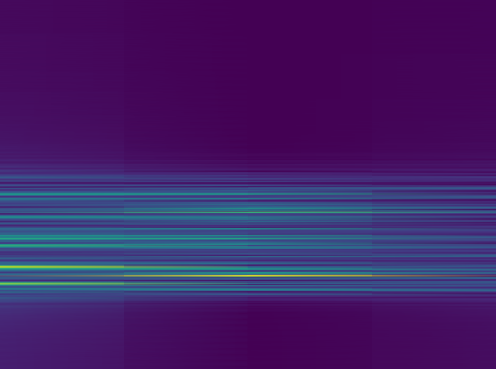

In [ ]:
sample_signal ,img_output , label = data_bp[5]
print(sample_signal.shape)
print(label)
display(img_output)

In [ ]:
img_1 = Image.open(img_output)

AttributeError: read